### Machine learning for predicting the magnetic flux rope structure in coronal mass ejections (Bz)

Coronal mass ejections continually interact with Earth's space weather environment driving geomagnetic storm activity. The severity of geomagnetic storms is determined by the magnetic flux rope structure in the coronal mass ejections. Predicting the flux rope structure is however an open question in the community. Here we study if the in situ signature in the sheath region contains sufficient information for predicting the magnetic flux rope field in coronal mass ejections. Further, we quantify how much time is needed inside the flux rope to predict the mean total magnetic field of the flux rope with high accuracy. To do so, we use widely-applied machine learning algorithms such as linear regression, lars lasso, and random forest. We train, test, and validate these algorithms on coronal mass ejections in retrospective real-time mode for the Wind, Stereo-A, and Stereo-B mission data in the HELCATS CME catalog. 

#### Contributors: 
M.A. Reiss, C. Möstl, R.L. Bailey, and U. Amerstorfer (Space Research Institute IWF, Graz, Austria)

#### Solar wind data:
Copy Version 8 from https://figshare.com/articles/dataset/Solar_wind_in_situ_data_suitable_for_machine_learning_python_numpy_arrays_STEREO-A_B_Wind_Parker_Solar_Probe_Ulysses_Venus_Express_MESSENGER/12058065
into folder /data.

In [1]:
# Python Modules and Packages
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import cm
import numpy as np
import pickle
from scipy import stats
import scipy.io
import time

# Visualisation
import sunpy.time
import seaborn as sns
import pandas as pd
from pandas.plotting import scatter_matrix
from sunpy.time import parse_time

# Machine learning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import ElasticNet, HuberRegressor, Lars, LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor, RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Don't print warnings
import warnings
warnings.filterwarnings('ignore')

# Print versions
print('Current Versions')
import matplotlib
print(np.__version__)#==1.17.2
print(matplotlib.__version__)#3.1.2
print(scipy.__version__)#1.3.1
print(pd.__version__)#0.25.3
import sklearn
print(sklearn.__version__)#0.20.3
print(sns.__version__)#0.9.0
import PIL
print(PIL.__version__)#8.1.2

Current Versions
1.18.1
3.1.3
1.4.1
1.0.1
0.23.2
0.11.0
7.2.0


## 1. Data preparation

#### File and folder variables:

In [2]:
# Make plots and results folders
mfrdir = 'mfr_predict'
if os.path.isdir(mfrdir) == False: 
    os.mkdir(mfrdir)

plotdir = 'plots'
if os.path.isdir(plotdir) == False: 
    os.mkdir(plotdir)
    
# File names to save features into
savepath_win = 'wind_features.p'
savepath_sta = 'sta_features.p'
savepath_stb = 'stb_features.p'

#### Load HELCATS ICME data catalog

In [3]:
[ic,header,parameters] = pickle.load(open('data/HELCATS_ICMECAT_v20_pandas.p', "rb" ))

# Spacecraft
isc = ic.loc[:,'sc_insitu'] 

# Shock arrival or density enhancement time
icme_start_time = ic.loc[:,'icme_start_time']
icme_start_time_num = date2num(np.array(icme_start_time))

# Start time of the magnetic obstacle (mo)
mo_start_time = ic.loc[:,'mo_start_time']
mo_start_time_num = date2num(np.array(mo_start_time))

# End time of the magnetic obstacle (mo)
mo_end_time = ic.loc[:,'mo_end_time']
mo_end_time_num = date2num(np.array(mo_end_time))

#get indices for each target
wini=np.where(ic.sc_insitu=='Wind')[0]
stai=np.where(ic.sc_insitu=='STEREO-A')[0]
stbi=np.where(ic.sc_insitu=='STEREO-B')[0]
pspi=np.where(ic.sc_insitu=='PSP')[0]
soloi=np.where(ic.sc_insitu=='SolarOrbiter')[0]
bepii=np.where(ic.sc_insitu=='BepiColombo')[0]
ulyi=np.where(ic.sc_insitu=='Ulysses')[0]
messi=np.where(ic.sc_insitu=='Messenger')[0]
vexi=np.where(ic.sc_insitu=='VEX')[0]

#### Load spacecraft data

In [4]:
# Load Wind data
[win, winheader] = pickle.load(open("data/wind_2007_2021_heeq_ndarray.p", "rb"))

# Load STEREO-A data
[sta, atta] = pickle.load(open("data/stereoa_2007_2021_sceq_ndarray.p", "rb"))

# Load STEREO-B data
[stb, attb, stbheader] = pickle.load(open("data/stereob_2007_2014_sceq_ndarray.p", "rb"))

#### Study only events with a sheath region

In [5]:
# Event indices from STEREO and Wind
istaind = np.where(isc == 'STEREO-A')[0]
istbind = np.where(isc == 'STEREO-B')[0]
iwinind = np.where(isc == 'Wind')[0]

# Event indices where the start time of the CME does not match the start time of the magnetic obstacle
n_iwinind = np.where(icme_start_time_num[iwinind] != mo_start_time_num[iwinind])[0]
n_istaind = np.where(icme_start_time_num[istaind] != mo_start_time_num[istaind])[0]
n_istbind = np.where(icme_start_time_num[istbind] != mo_start_time_num[istbind])[0]

# Correct indicies to take from all data, not just subset
i_icme_start_time_num = np.arange(len(icme_start_time_num))
n_iwinind = i_icme_start_time_num[iwinind][n_iwinind]
n_istaind = i_icme_start_time_num[istaind][n_istaind]
n_istbind = i_icme_start_time_num[istbind][n_istbind]

# Count the number of selected events
print("Events with a sheath region in WIND    : {} / {}".format(n_iwinind.shape[0], iwinind.shape[0]))   # TODO
print("Events with a sheath region in STEREO-A: {} / {}".format(n_istaind.shape[0], istaind.shape[0]))
print("Events with a sheath region in STEREO-B: {} / {}".format(n_istbind.shape[0], istbind.shape[0]))
print("Number of Events with a sheath region  :", n_iwinind.shape[0] + n_istaind.shape[0] + n_istbind.shape[0])
print('Percentage of all events',np.round((n_iwinind.shape[0] + n_istaind.shape[0] + n_istbind.shape[0])/ (np.size(stbi)+np.size(wini)+np.size(stai))*100))

# Indices of all selected events
n_all=np.hstack([n_iwinind,n_istaind,n_istbind])

Events with a sheath region in WIND    : 149 / 186
Events with a sheath region in STEREO-A: 135 / 222
Events with a sheath region in STEREO-B: 78 / 150
Number of Events with a sheath region  : 362
Percentage of all events 65.0


In [6]:
print('Statistics for the selected events with sheath:')
print()
print("Average ICME length   : {:.2f} hours".format(((mo_end_time_num[n_all] - icme_start_time_num[n_all])*24.).mean()))
print("Average MO length     : {:.2f} hours".format(((mo_end_time_num[n_all] - mo_start_time_num[n_all])*24.).mean()))
print("Average SHEATH length : {:.2f} hours".format(((mo_start_time_num[n_all] - icme_start_time_num[n_all])*24.).mean()))
print()
print("STD ICME length       : {:.2f} hours".format(((mo_end_time_num[n_all] - icme_start_time_num[n_all])*24.).std()))
print("STD MO length         : {:.2f} hours".format(((mo_end_time_num[n_all] - mo_start_time_num[n_all])*24.).std()))
print("STD SHEATH length     : {:.2f} hours".format(((mo_start_time_num[n_all] - icme_start_time_num[n_all])*24.).std()))

Statistics for the selected events with sheath:

Average ICME length   : 34.01 hours
Average MO length     : 25.16 hours
Average SHEATH length : 8.85 hours

STD ICME length       : 17.11 hours
STD MO length         : 14.80 hours
STD SHEATH length     : 6.18 hours


## Figure 1: ICME catalog

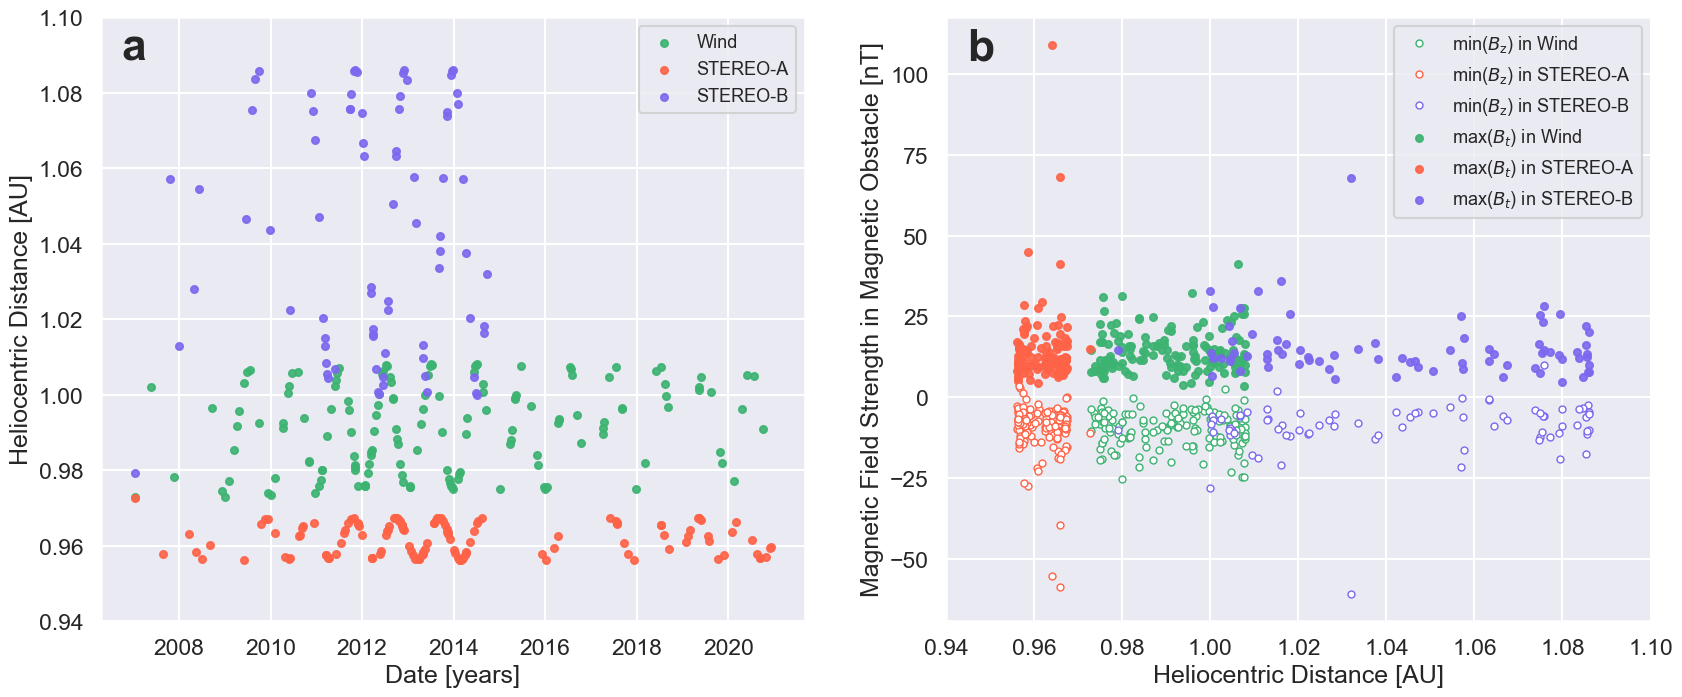

Selected events with sheath:
Number of events: Wind,  149
Number of events: STA,  135
Number of events: STB,  78
Total: 362


In [7]:
#markersize
ms=25
#alpha
al=0.9

sns.set_context("talk")     
sns.set_style('darkgrid')

fig=plt.figure(figsize=(20,8),dpi=100)
ax1 = plt.subplot(121) 
ax1.scatter(ic.loc[n_iwinind,'icme_start_time'], ic.loc[n_iwinind,'mo_sc_heliodistance'], label='Wind', s=ms,c='mediumseagreen', alpha=al)
ax1.scatter(ic.loc[n_istaind,'icme_start_time'], ic.loc[n_istaind,'mo_sc_heliodistance'], label='STEREO-A',s=ms,c='tomato', alpha=al)
ax1.scatter(ic.loc[n_istbind,'icme_start_time'], ic.loc[n_istbind,'mo_sc_heliodistance'], label='STEREO-B',s=ms,c='mediumslateblue', alpha=al)
plt.ylabel('Heliocentric Distance [AU]')
plt.xlabel('Date [years]')
plt.ylim([0.94,1.1])
plt.legend(loc=1,fontsize=13)

ax2 = plt.subplot(122) 
#ax2.scatter(ic.loc[wini,'mo_sc_heliodistance'],ic.loc[wini,'mo_bmean'], label='Wind', s=ms,c='mediumseagreen', alpha=al)
#ax2.scatter(ic.loc[stai,'mo_sc_heliodistance'],ic.loc[stai,'mo_bmean'], label='STEREO-A',s=ms,c='red', alpha=al)
#ax2.scatter(ic.loc[stbi,'mo_sc_heliodistance'],ic.loc[stbi,'mo_bmean'], label='STEREO-B',s=ms,c='blue', alpha=al)
ax2.scatter(ic.loc[n_iwinind,'mo_sc_heliodistance'],ic.loc[n_iwinind,'mo_bmax'], label='max($B_t$) in Wind', s=ms,c='mediumseagreen', alpha=al)
ax2.scatter(ic.loc[n_istaind,'mo_sc_heliodistance'],ic.loc[n_istaind,'mo_bmax'], label='max($B_t$) in STEREO-A',s=ms,c='tomato', alpha=al)
ax2.scatter(ic.loc[n_istbind,'mo_sc_heliodistance'],ic.loc[n_istbind,'mo_bmax'], label='max($B_t$) in STEREO-B',s=ms,c='mediumslateblue', alpha=al)

al=1.0
ax2.plot(ic.loc[n_iwinind,'mo_sc_heliodistance'],ic.loc[n_iwinind,'mo_bzmin'], linestyle='None',marker='o',ms=5,c='mediumseagreen',markerfacecolor='white',label='min($B_{\mathrm{z}}$) in Wind', alpha=al)
ax2.plot(ic.loc[n_istaind,'mo_sc_heliodistance'],ic.loc[n_istaind,'mo_bzmin'], linestyle='None',marker='o',ms=5,label='min($B_{\mathrm{z}}$) in STEREO-A',markerfacecolor='white',c='tomato', alpha=al)
ax2.plot(ic.loc[n_istbind,'mo_sc_heliodistance'],ic.loc[n_istbind,'mo_bzmin'], linestyle='None',marker='o',ms=5,label='min($B_{\mathrm{z}}$) in STEREO-B',markerfacecolor='white',c='mediumslateblue', alpha=al)
ax2.set_xlabel('Heliocentric Distance [AU]')
ax2.set_ylabel('Magnetic Field Strength in Magnetic Obstacle [nT]')
ax2.set_xlim([0.94,1.1])
ax2.legend(loc=1,fontsize=13)

# Add labels to plots
for ax, ann in zip([ax1, ax2], ['a', 'b']):
    ax.text(0.03, .93, ann, transform=ax.transAxes, fontsize=32, weight='bold')

#for ax, ann in zip([ax1, ax2], ['a', 'b']):
#    ax.text(0.02, .93, ann, transform=ax.transAxes, fontsize=32, weight='bold')
argv3 ='fig1_icmecat.pdf'
plt.savefig('plots/' + argv3, bbox_inches='tight')
argv3 ='fig1_icmecat.png'
plt.savefig('plots/' + argv3, bbox_inches='tight')
plt.show()

print('Selected events with sheath:')
print('Number of events: Wind, ',np.size(n_iwinind))
print('Number of events: STA, ',np.size(n_istaind))
print('Number of events: STB, ',np.size(n_istbind))
print('Total:',np.size(n_iwinind)+np.size(n_istaind)+np.size(n_istbind))

## Figure 2: Parameter distribution plot

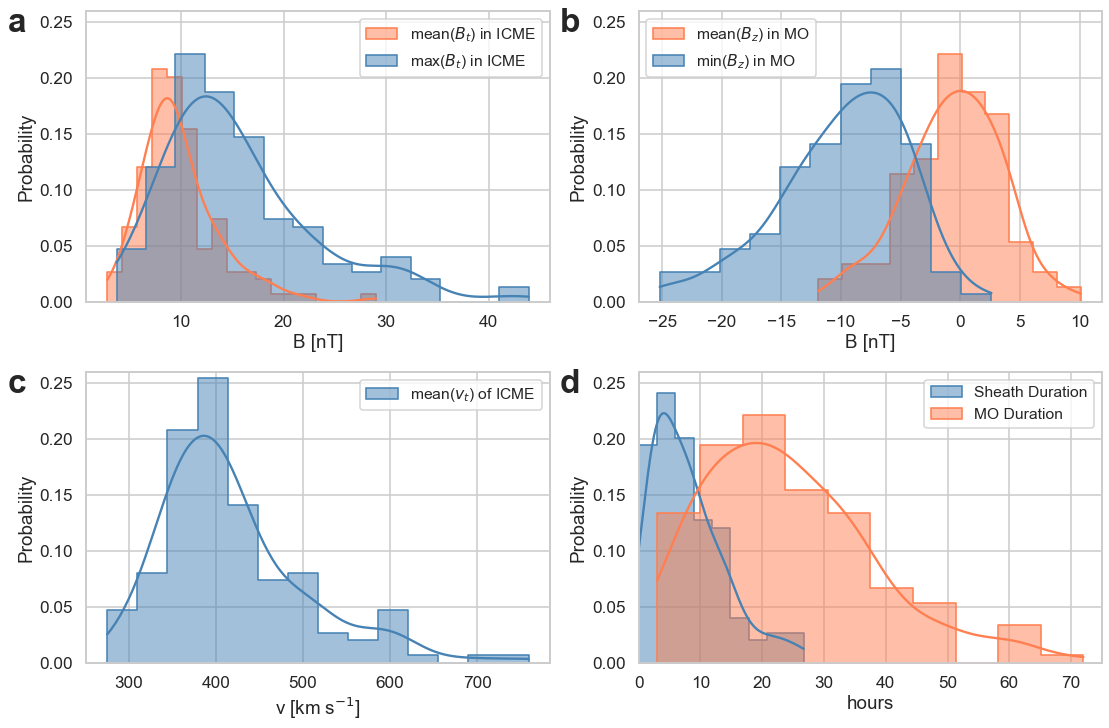

In [8]:
#make distribution plots
#plt.figure(10,figsize=(12,5))
#sns.histplot(ic.mo_sc_heliodistance)

sns.set_context("talk")     
sns.set_style('whitegrid')

fig=plt.figure(figsize=(15,10),dpi=75)

fs=15
ax1 = plt.subplot(221) 
sns.histplot(ic.loc[n_iwinind,'icme_bmean'], label='mean($B_t$) in ICME',color='coral',alpha=0.5,kde=True,stat='probability',element='step')
sns.histplot(ic.loc[n_iwinind,'icme_bmax'], label='max($B_t$) in ICME',color='steelblue',kde=True,stat='probability', element='step')
ax1.set_xlabel('B [nT]')
ax1.set_ylim(0,0.26)
plt.legend(loc=1,fontsize=fs)

ax2 = plt.subplot(222) 
sns.histplot(ic.loc[n_iwinind,'mo_bzmean'],label='mean($B_z$) in MO',color='coral',alpha=0.5,kde=True,stat='probability', element='step')
sns.histplot(ic.loc[n_iwinind,'mo_bzmin'],label='min($B_z$) in MO',color='steelblue',kde=True,stat='probability', element='step')
ax2.set_xlabel('B [nT]')
#ax2.set_ylabel('')
ax2.set_ylim(0,0.26)
plt.legend(loc=2,fontsize=fs)

ax3 = plt.subplot(223) 
sns.histplot(ic.loc[n_iwinind,'icme_speed_mean'],label='mean($v_t$) of ICME',color='steelblue',kde=True,stat='probability', element='step')
ax3.set_xlabel('v [km s$^{-1}$]')
ax3.set_ylim(0,0.26)
plt.legend(loc=1,fontsize=fs)

ax4 = plt.subplot(224) 
sns.histplot(ic.loc[n_iwinind,'icme_duration']-ic.loc[n_iwinind,'mo_duration'],label='Sheath Duration',color='steelblue',kde=True,stat='probability', element='step')
sns.histplot(ic.loc[n_iwinind,'mo_duration'],label='MO Duration',color='coral',kde=True,stat='probability', element='step')
ax4.set_xlabel('hours')
ax4.set_ylim(0,0.26)
ax4.set_xlim(0,75)
#ax4.set_ylabel('')
plt.legend(loc=1,fontsize=fs)

#ax4 = plt.subplot(234) 
#sns.histplot(ic.loc[n_iwinind,'mo_density_mean'],label='MO <$N_p$>',color='steelblue',kde=True,stat='probability', element='step')
#ax4.set_xlabel('N [ccm$^{-3}$]')#
#ax4.set_ylim(0,0.25)
#ax4.set_ylabel('')
#plt.legend(loc=1)

#ax5 = plt.subplot(235) 
#sns.histplot(ic.loc[n_iwinind,'mo_temperature_mean'],label='MO <$T_p$>',color='steelblue',kde=True,stat='probability', element='step')
#ax5.set_xlabel('hours')
#ax5.set_ylim(0,0.25)#
#ax5.set_ylabel('')
#plt.legend(loc=1)
#plt.tight_layout()

plt.tight_layout()

# Add labels to plots
for ax, ann in zip([ax1, ax2, ax3, ax4], ['a', 'b','c','d']):
    ax.text(-0.17, .93, ann, transform=ax.transAxes, fontsize=32, weight='bold')

argv3 ='fig2_dist.pdf'
plt.savefig('plots/' + argv3)
argv3 ='fig2_dist.png'
plt.savefig('plots/' + argv3)

#### Timing windows for features and labels

In [9]:
# Set time window for features in hours
feature_hours = 4 #10

# Decide if you want to include the sheath region. 
use_sheath = True

if use_sheath:
    print("Option 1: Use MFR and sheath data for features")
    event_start = icme_start_time_num
else:
    print("Option 2: Use MFR and no sheath data for features")
    event_start = mo_start_time_num

# Define end of the event time window
event_end = mo_start_time_num + feature_hours / 24.0
      
# Define timing window of labels
label_start = mo_start_time_num
label_end = mo_end_time_num

Option 1: Use MFR and sheath data for features


#### Functions to compute features and labels

In [10]:
# Compute mean, max and std-dev in feature time window
def get_feature(sc_time, start_time, end_time, sc_ind, sc_feature):
    feature_mean = np.zeros(np.size(sc_ind))
    feature_max = np.zeros(np.size(sc_ind))
    feature_std = np.zeros(np.size(sc_ind))
    feature_min = np.zeros(np.size(sc_ind))
    feature_cv  = np.zeros(np.size(sc_ind))
    feature_minmax = np.zeros(np.size(sc_ind))
    
    for p in np.arange(0, np.size(sc_ind)):
        time_slice = np.where(np.logical_and(sc_time > start_time[sc_ind[p]], sc_time < end_time[sc_ind[p]]))
        feature_slice = sc_feature[time_slice]
        feature_mean[p] = np.nanmean(feature_slice)
        feature_std[p] = np.nanstd(feature_slice)
        
        # Compute coefficient of variation (CV)
        feature_cv[p] = feature_std[p]/np.abs(feature_mean[p])
        
        feature_temp = feature_slice[np.isfinite(feature_slice)]
        try:
            feature_max[p] = np.max(feature_temp)
            feature_min[p] = np.min(feature_temp)
            feature_minmax[p] = feature_min[p]/feature_max[p]
        except ValueError:  # raised if `y` is empty.
            pass

    return feature_mean, feature_max, feature_std, feature_min, feature_cv, feature_minmax

# Compute either 'max' or 'mean' of total magnetic field in label time window
def get_label(sc_time, start_time, end_time, sc_ind, sc_label, label_type="max"):
    label_mean = np.zeros(np.size(sc_ind))
    label_max = np.zeros(np.size(sc_ind))
    label_min = np.zeros(np.size(sc_ind))

    for p in np.arange(0, np.size(sc_ind)):
        time_slice = np.where(np.logical_and(sc_time > start_time[sc_ind[p]], sc_time < end_time[sc_ind[p]]))
        label_slice = sc_label[time_slice]
        if len(label_slice) == 0:
            label_max[p] = np.nan
            label_min[p] = np.nan
            label_mean[p] = np.nan
        else:
            label_max[p] = np.nanmax(label_slice)
            label_min[p] = np.min([np.nanmin(label_slice), 0])
            label_mean[p] = np.nanmean(label_slice)
            
    if label_type == 'max':
        return label_max
    elif label_type == 'min':
        return label_min
    elif label_type == 'mean':
        return label_mean

#### Create data frame for features and labels

In [11]:
import time
# Compute either 'max' or 'mean' of total magnetic field in label time window
target_type = 'min'

# List of physical properties
variable_list = ['bx', 'by', 'bz', 'bt', 'vt','np','tp']


# If file doesn't exist, create it, otherwise load it
if not os.path.exists("mfr_predict/bz_fh{:.0f}_sta_features.p".format(feature_hours)):
    start_time = time.time()
    print("Option 1: Compute features...")

    # Wind features
    dwin = {}
    for variable in variable_list:
        all_var_features = get_feature(win['time'], event_start, event_end, n_iwinind, win[variable])
        dwin['mean('+variable+')'] = all_var_features[0]
        dwin['max('+variable+')'] = all_var_features[1]
        dwin['std('+variable+')'] = all_var_features[2]
        dwin['min('+variable+')'] = all_var_features[3]
        dwin['cv('+variable+')'] = all_var_features[4]
        dwin['minmax('+variable+')'] = all_var_features[5]

    # Wind labels
    label_btotmean = get_label(win['time'], label_start, label_end, n_iwinind, win['bz'], label_type=target_type)
    dwin['Target'] = label_btotmean
    
    # Create dataframe
    dfwin = pd.DataFrame(data=dwin)
    pickle.dump(dfwin, open(os.path.join(mfrdir, 'bz_fh{:.0f}_'.format(feature_hours) + savepath_win), "wb"))
    
    # STEREO-A features
    dsta = {}
    for variable in variable_list:
        all_var_features = get_feature(sta['time'], event_start, event_end, 
                                       n_istaind, sta[variable])
        dsta['mean('+variable+')'] = all_var_features[0]
        dsta['max('+variable+')'] = all_var_features[1]
        dsta['std('+variable+')'] = all_var_features[2]
        dsta['min('+variable+')'] = all_var_features[3]
        dsta['cv('+variable+')'] = all_var_features[4]
        dsta['minmax('+variable+')'] = all_var_features[5]

    # STEREO-A labels
    label_btotmean = get_label(sta['time'], label_start, label_end, n_istaind, sta['bz'], label_type=target_type)
    dsta['Target'] = label_btotmean
    
    # Create dateframe
    dfsta = pd.DataFrame(data=dsta)
    pickle.dump(dfsta, open(os.path.join(mfrdir, 'bz_fh{:.0f}_'.format(feature_hours) + savepath_sta), "wb"))
    
    # STEREO-B features
    dstb = {}
    for variable in variable_list:
        all_var_features = get_feature(stb['time'], event_start, event_end, 
                                       n_istbind, stb[variable])
        dstb['mean('+variable+')'] = all_var_features[0]
        dstb['max('+variable+')'] = all_var_features[1]
        dstb['std('+variable+')'] = all_var_features[2]
        dstb['min('+variable+')'] = all_var_features[3]
        dstb['cv('+variable+')'] = all_var_features[4]
        dstb['minmax('+variable+')'] = all_var_features[5]

    # STEREO-B labels
    label_btotmean = get_label(stb['time'], label_start, label_end, n_istbind, stb['bz'], label_type=target_type)
    dstb['Target'] = label_btotmean
    
    # Create dataframe
    dfstb = pd.DataFrame(data=dstb)
    pickle.dump(dfstb, open(os.path.join(mfrdir, 'bz_fh{:.0f}_'.format(feature_hours) + savepath_stb), "wb"))
    print("Option 1: Computation of data frame for Wind, STEREO-A, and STEREO-B completed")   
    end_time = time.time()
    print("Computation of features took {:.1f} minutes.".format((end_time - start_time)/60.))
else:
    print("Option 2: Loading existing data frames...")
    dfwin = pickle.load(open(os.path.join(mfrdir, 'bz_fh{:.0f}_'.format(feature_hours) + savepath_win), "rb"))
    dfsta = pickle.load(open(os.path.join(mfrdir, 'bz_fh{:.0f}_'.format(feature_hours) + savepath_sta), "rb"))
    dfstb = pickle.load(open(os.path.join(mfrdir, 'bz_fh{:.0f}_'.format(feature_hours) + savepath_stb), "rb"))
    print("Option 2: Loading existing data frame completed")

Option 2: Loading existing data frames...
Option 2: Loading existing data frame completed


#### Clean the data frame by removing NaNs 

In [12]:
# Events before tidying up
len_dfwin_nans = len(dfwin)
len_dfsta_nans = len(dfsta)
len_dfstb_nans = len(dfstb)

# Remove NaN's in data frames
dfwin = dfwin.dropna()
dfsta = dfsta.dropna()
dfstb = dfstb.dropna()

print("{} nans removed from WIND data".format(len_dfwin_nans-len(dfwin)))
print("{} nans removed from STEREO-A data".format(len_dfsta_nans-len(dfsta)))
print("{} nans removed from STEREO-B data".format(len_dfstb_nans-len(dfstb)))
print("Total number of events left:  ", len(dfwin)+len(dfsta)+len(dfstb))

0 nans removed from WIND data
12 nans removed from STEREO-A data
2 nans removed from STEREO-B data
Total number of events left:   348


In [13]:
"""#Some tests...
event_num = 5
time_event = stb['time'][np.logical_and(stb['time'] > icme_start_time_num[n_istbind][event_num], stb['time'] < mo_start_time_num[n_istbind][event_num]+ feature_hours / 24.0)]
prop_event = stb['bt'][np.logical_and(stb['time'] > icme_start_time_num[n_istbind][event_num], stb['time'] < mo_start_time_num[n_istbind][event_num]+ feature_hours / 24.0)]
time_label = stb['time'][np.logical_and(stb['time'] > mo_start_time_num[n_istbind][event_num]+ feature_hours / 24.0, stb['time'] < mo_end_time_num[n_istbind][event_num])]
prop_label = stb['bt'][np.logical_and(stb['time'] > mo_start_time_num[n_istbind][event_num]+ feature_hours / 24.0, stb['time'] < mo_end_time_num[n_istbind][event_num])]
plt.plot(time_event,prop_event)
plt.plot(time_label,prop_label)
plt.scatter(icme_start_time_num[n_istbind][event_num],0.6, color='y')
plt.axvline(icme_start_time_num[n_istbind][event_num], color='y')
plt.scatter(mo_start_time_num[n_istbind][event_num],0.5, color='g')
plt.scatter(mo_start_time_num[n_istbind][event_num] + feature_hours / 24.0,0.4, color='b')
plt.scatter(mo_end_time_num[n_istbind][event_num],0.3, color='r')

print(np.nanmean(prop_event))
print(np.nanmax(prop_event))
print(np.nanstd(prop_event))
print(np.nanmin(prop_event))
print(np.nanstd(prop_event)/np.nanmean(prop_event))
print(np.nanmin(prop_event)/np.nanmax(prop_event))
#print(np.nanmean(prop_label))stb
"""

"#Some tests...\nevent_num = 5\ntime_event = stb['time'][np.logical_and(stb['time'] > icme_start_time_num[n_istbind][event_num], stb['time'] < mo_start_time_num[n_istbind][event_num]+ feature_hours / 24.0)]\nprop_event = stb['bt'][np.logical_and(stb['time'] > icme_start_time_num[n_istbind][event_num], stb['time'] < mo_start_time_num[n_istbind][event_num]+ feature_hours / 24.0)]\ntime_label = stb['time'][np.logical_and(stb['time'] > mo_start_time_num[n_istbind][event_num]+ feature_hours / 24.0, stb['time'] < mo_end_time_num[n_istbind][event_num])]\nprop_label = stb['bt'][np.logical_and(stb['time'] > mo_start_time_num[n_istbind][event_num]+ feature_hours / 24.0, stb['time'] < mo_end_time_num[n_istbind][event_num])]\nplt.plot(time_event,prop_event)\nplt.plot(time_label,prop_label)\nplt.scatter(icme_start_time_num[n_istbind][event_num],0.6, color='y')\nplt.axvline(icme_start_time_num[n_istbind][event_num], color='y')\nplt.scatter(mo_start_time_num[n_istbind][event_num],0.5, color='g')\nplt

## 2. Machine Learning

#### Split data frame into training and testing

In [14]:
# Testing data size in percent
test_size = 0.3

# Split into training and testing data
win_train, win_test = train_test_split(dfwin, test_size=test_size, random_state=42)
sta_train, sta_test = train_test_split(dfsta, test_size=test_size, random_state=42)
stb_train, stb_test = train_test_split(dfstb, test_size=test_size, random_state=42)

# Combine spacecraft datasets
train = pd.concat([win_train, sta_train, stb_train])
test = pd.concat([win_test, sta_test, stb_test])

# Save the index of the events, as appearing in the data frames, to a numpy array
win_train_ind = win_train.index.to_numpy()
win_test_ind  = win_test.index.to_numpy()
sta_train_ind = sta_train.index.to_numpy()
sta_test_ind  = sta_test.index.to_numpy()
stb_train_ind = stb_train.index.to_numpy()
stb_test_ind  = stb_test.index.to_numpy()

# Calculate indices for training and testing data frame
train_ind = train.index.to_numpy()
test_ind = test.index.to_numpy()

# Some useful stuff:
# train.info()
# train.describe()

#### Feature selection

In [15]:
# Select features
use_features = list(train.columns)
use_features.remove('Target')

# Bring data into shape for machine learning models
if len(use_features) == 1:
    X_train = np.array(train[use_features]).reshape(-1, 1)
    X_test = np.array(test[use_features]).reshape(-1, 1)
else:
    X_train = np.array(train[use_features])
    X_test = np.array(test[use_features])
    
y_train = np.array(train['Target']).reshape(-1, 1)
y_test = np.array(test['Target']).reshape(-1, 1)

# Use pickle to save training and testing data
fname = os.path.join(mfrdir, 'fh{:.0f}_train_test_data.p'.format(feature_hours))
pickle.dump([n_iwinind, n_istaind, n_istbind, 
             win_train_ind, win_test_ind, 
             sta_train_ind, sta_test_ind, 
             stb_train_ind, stb_test_ind, 
             train_ind, test_ind, 
             X_train, X_test, y_train, y_test, 
             feature_hours], open(fname, 'wb'))

#### Select algorithms for machine learning

In [16]:
# Define machine learning models
def get_models(models=dict()):
    models['lr'] = LinearRegression()
    models['lasso'] = Lasso()
    models['ridge'] = Ridge()
    models['en'] = ElasticNet()
    models['rfr'] = RandomForestRegressor()
    models['gbr'] = GradientBoostingRegressor()
    return models

# Fit model, evaluate it and get scores
def sklearn_predict(model, X, y):
    # fit the model
    model.fit(X, y)
    # prediction
    y_predict = model.predict(X)
    score, mean_score, std_score = evaluate_forecast(model, X, y, y_predict)
    return score, mean_score, std_score, y_predict

# Define scores
def evaluate_forecast(model, X, y, y_predict):
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    score = np.sqrt(-scores)
    mean_score = score.mean()  # root mean squared error
    std_score = score.std()
    return score, mean_score, std_score

#### Test different machine learning algorithms

In [17]:
# Use pickle to load training and testing data
savepath_traintest ='fh{:.0f}_train_test_data.p'.format(feature_hours)
fname = 'mfr_predict/' + savepath_traintest
[n_iwinind, n_istaind, n_istbind, win_train_ind, win_test_ind, sta_train_ind, sta_test_ind, 
     stb_train_ind, stb_test_ind, train_ind, test_ind, 
     X_train, X_test, y_train, y_test, feature_hours] = pickle.load(open(fname, 'rb'))

# Get different machine learning models
models = get_models()

# Define seed to compare the results
np.random.seed(42)

mean_score = np.zeros(len(models))
std_score = np.zeros(len(models))
imod = 0

print("{:<10}{:<6}{:<6}".format("Model", "PCC", "MAE"))
for name, model in models.items():
    # fit model, evaluate and get scores
    score, mean_score[imod], std_score[imod], y_predict = sklearn_predict(model, X_train, y_train)
    # summarize scores
    ppmc = scipy.stats.pearsonr(np.squeeze(y_train), np.squeeze(y_predict))[0]
    mae = mean_absolute_error(np.squeeze(y_train), np.squeeze(y_predict))
    print("{:<10}{:6.2f}{:6.2f}".format(name, ppmc, mae))

Model     PCC   MAE   
lr          0.87  2.48
lasso       0.83  2.87
ridge       0.87  2.47
en          0.84  2.76
rfr         0.97  1.15
gbr         0.99  0.82


#### Validation of machine learning models

In [18]:
# Validate machine learning model on test data
print("{:<10}{:<6}{:<6}".format("Model", "PCC", "RMSE"))
for name, model in models.items():
    y_pred1 = models[name].predict(X_test)
    mae1 = mean_absolute_error(np.squeeze(y_test), np.squeeze(y_pred1))
    cc1 = scipy.stats.pearsonr(np.squeeze(y_test), np.squeeze(y_pred1))[0]
    print("{:<10}{:6.2f}{:6.2f}".format(name, cc1, mae1))

Model     PCC   RMSE  
lr          0.32  4.80
lasso       0.71  3.63
ridge       0.30  4.91
en          0.73  3.58
rfr         0.68  3.20
gbr         0.62  3.32


#### Optimising model hyperparameters

In [19]:
# Set to True when you want to redo the Hyperparameter tuning - takes a few minutes
# [ToDo] Need to check why the results are not improving with the tuning...
gridsearch = False

from sklearn.model_selection import RandomizedSearchCV

In [20]:
if gridsearch:
    gbr_param_grid = {'n_estimators': [100, 200, 300, 400],
                      'min_samples_split': [2, 3, 4, 5],
                      'min_samples_leaf': [1, 2, 3, 4],
                      'max_depth': [2, 3, 4, 5],
                      'learning_rate': [0.01, 0.1]}
    clf_gbr = GradientBoostingRegressor()
    clf = RandomizedSearchCV(clf_gbr, gbr_param_grid, n_iter=200, cv=3, verbose=1)
    cv_model = clf.fit(X_train, y_train)
    best_params_gbr = cv_model.best_params_
else:
    best_params_gbr = {'n_estimators': 400, 'min_samples_split': 5, 
                       'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.1}
    
print(best_params_gbr)
models['gbr'] = GradientBoostingRegressor(**best_params_gbr)
score, _, _, y_predict_opt = sklearn_predict(models['gbr'], X_train, y_train)
# summarize scores
print("GBR Grid Search Hyperparameter Tuning results:")
ppmc = scipy.stats.pearsonr(np.squeeze(y_train), np.squeeze(y_predict_opt))[0]
mae = mean_absolute_error(np.squeeze(y_train), np.squeeze(y_predict_opt))
print("{:<10}{:6.2f}{:6.2f}".format('train', ppmc, mae))

y_pred1 = models['gbr'].predict(X_test)
mae1 = mean_absolute_error(np.squeeze(y_test), np.squeeze(y_pred1))
cc1 = scipy.stats.pearsonr(np.squeeze(y_test), np.squeeze(y_pred1))[0]
print("{:<10}{:6.2f}{:6.2f}".format('test', cc1, mae1))

{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.1}
GBR Grid Search Hyperparameter Tuning results:
train       1.00  0.03
test        0.67  3.36


In [21]:
if gridsearch:
    rfr_param_grid = {'n_estimators': [100, 200, 300, 400],
                      'min_samples_split': [2, 3, 4, 5],
                      'min_samples_leaf': [1, 2, 3, 4],
                      'max_depth': [2, 3, 4, 5]}
    rfr_clf = RandomForestRegressor()
    clf_rfr = RandomizedSearchCV(rfr_clf, rfr_param_grid, n_iter=200, cv=3, verbose=1)
    cv_model_rfr = clf_rfr.fit(X_train, y_train)
    best_params_rfr = cv_model_rfr.best_params_
else:
    best_params_rfr = {'n_estimators': 300, 'min_samples_split': 4, 
                       'min_samples_leaf': 1, 'max_depth': 5}
    
print(best_params_rfr)
models['rfr'] = RandomForestRegressor(**best_params_rfr)
score, _, _, y_predict_opt = sklearn_predict(models['rfr'], X_train, y_train)
# summarize scores
print("")
print("RFR Grid Search Hyperparameter Tuning Results:")
ppmc = scipy.stats.pearsonr(np.squeeze(y_train), np.squeeze(y_predict_opt))[0]
mae = mean_absolute_error(np.squeeze(y_train), np.squeeze(y_predict_opt))
print("{:<10}{:6.2f}{:6.2f}".format('train', ppmc, mae))

y_pred1 = models['rfr'].predict(X_test)
mae1 = mean_absolute_error(np.squeeze(y_test), np.squeeze(y_pred1))
cc1 = scipy.stats.pearsonr(np.squeeze(y_test), np.squeeze(y_pred1))[0]
print("{:<10}{:6.2f}{:6.2f}".format('test', cc1, mae1))

{'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 5}

RFR Grid Search Hyperparameter Tuning Results:
train       0.93  2.06
test        0.70  3.17


In [22]:
# Select best models according to scores
model1 = models['lr'] 
model2 = models['rfr'] 
model3 = models['gbr'] 

y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)

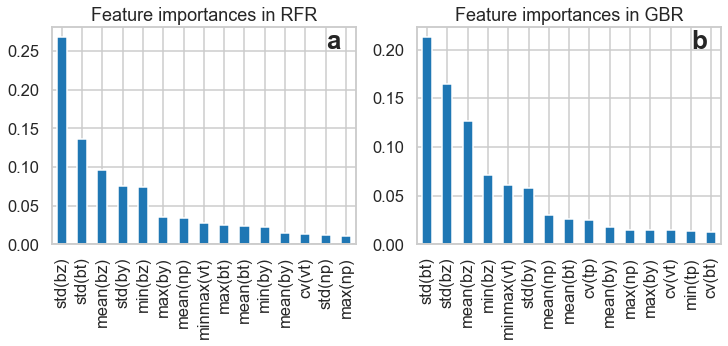

In [23]:
importances = model3.feature_importances_
indices = np.argsort(importances)
feat_imps_rfr = pd.Series(model2.feature_importances_, use_features).sort_values(ascending=False)[0:15]
feat_imps_gbr = pd.Series(model3.feature_importances_, use_features).sort_values(ascending=False)[0:15]

# Plot the feature importances of the forest
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
feat_imps_rfr.plot(kind='bar', title="Feature importances in RFR", ax=ax1)
feat_imps_gbr.plot(kind='bar', title="Feature importances in GBR", ax=ax2)

plt.subplots_adjust(wspace=0.2)

# Possible method of interpretation for LR:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html

for ax, ann in zip([ax1, ax2], ['a', 'b']):
    ax.text(.9, .9, ann, transform=ax.transAxes, fontsize=26, weight='bold')

argv3='feature_importance_minbz_{}h.pdf'.format(feature_hours)  
plt.savefig('plots/' + argv3, bbox_inches='tight')
plt.show()

In [24]:
# (n, 1) -- (n,)
y_test = np.squeeze(y_test)
y_pred1 = np.squeeze(y_pred1)
y_pred2 = np.squeeze(y_pred2)
y_pred3 = np.squeeze(y_pred3)
# (n,) -- (n, 1)
#y_pred1 = y_pred1.reshape(-1,1)

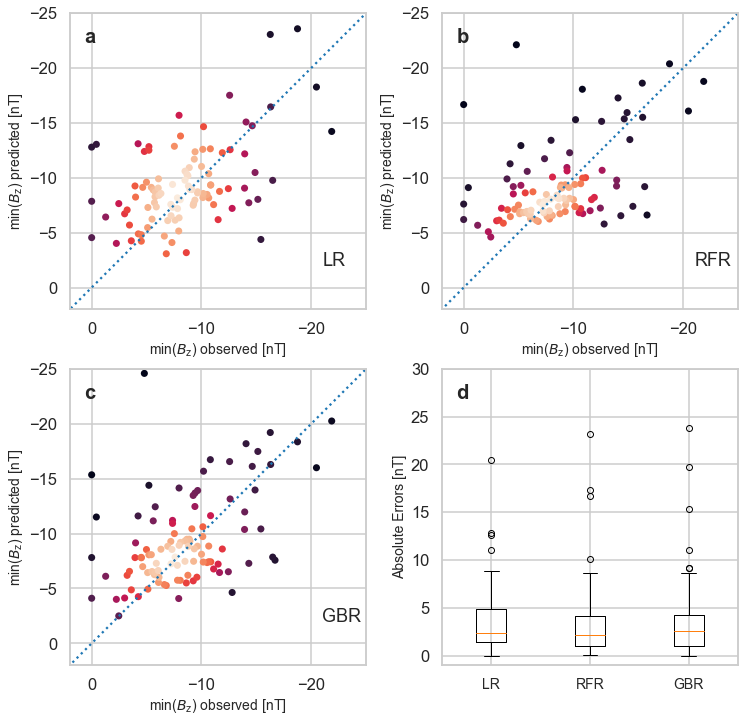

In [25]:
# Create scatter density plots for different models
from scipy.stats import gaussian_kde

fig, [(ax1,ax2),(ax3,ax4)] = plt.subplots(2, 2,figsize=(12,12))

x = y_test
y = y_pred1
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

ax1.scatter(x, y, c=z, s=50, edgecolor='')
ax1.set_xlim([2,-25])
ax1.set_ylim([2,-25])
ax1.set_aspect('equal', 'box')
ax1.text(-21, -2, 'LR', fontsize=18)
ax1.set_xlabel('min($B_{\mathrm{z}}$) observed [nT]', fontsize=14)
ax1.set_ylabel('min($B_{\mathrm{z}}$) predicted [nT]', fontsize=14)
ax1.plot([-100, 100],[-100, 100], ls=":")

x = y_test
y = y_pred2
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

ax2.scatter(x, y, c=z, s=50, edgecolor='')
ax2.set_xlim([2,-25])
ax2.set_ylim([2,-25])
ax2.set_aspect('equal', 'box')
ax2.text(-21, -2, 'RFR', fontsize=18)
ax2.set_xlabel('min($B_{\mathrm{z}}$) observed [nT]', fontsize=14)
ax2.set_ylabel('min($B_{\mathrm{z}}$) predicted [nT]', fontsize=14)
ax2.plot([-100, 100],[-100,100], ls=":")

x = y_test
y = y_pred3
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

ax3.plot([-100, 100],[-100, 100], ls=":")
ax3.scatter(x, y, c=z, s=50, edgecolor='')
ax3.set_xlim([2,-25])
ax3.set_ylim([2,-25])
ax3.set_aspect('equal', 'box')
ax3.text(-21, -2, 'GBR', fontsize=18)
ax3.set_xlabel('min($B_{\mathrm{z}}$) observed [nT]', fontsize=14)
ax3.set_ylabel('min($B_{\mathrm{z}}$) predicted [nT]', fontsize=14)
ax4.boxplot([np.abs(y_test-y_pred1),np.abs(y_test-y_pred2),np.abs(y_test-y_pred3)])
ax4.set_ylim([-1,30])

plt.xticks([1, 2, 3], ['LR', 'RFR', 'GBR'], fontsize=14)
asp = np.diff(ax4.get_xlim())[0] / np.diff(ax4.get_ylim())[0]
ax4.set_aspect(asp)
ax4.set_ylabel('Absolute Errors [nT]', fontsize=14)

plt.subplots_adjust(wspace=0.25)
for ax, ann in zip([ax1, ax2, ax3, ax4], ['a', 'b', 'c', 'd']):
    ax.text(.05, .9, ann, transform=ax.transAxes, fontsize=20, weight='bold')

argv3='scatter_plot_minbz_{}h.pdf'.format(feature_hours)  
plt.savefig('plots/' + argv3, bbox_inches='tight')
plt.show()

#### Point-to-point comparison metrics

In [26]:
import sklearn

def meanError(mod, obs):
    me = obs.mean() - mod.mean()
    return me

def meanAbsoluteError(mod, obs):
    mae = (np.abs(obs - mod)).mean()
    return mae

def meanSquaredError(mod, obs):
    mse = ((obs - mod) ** 2).mean()
    return mse

def rootMeanSquaredError(mod, obs):
    rmse = np.sqrt(((obs - mod) ** 2).mean())
    return rmse

def skillScore(mod, obs):
    refDF = np.full(obs.shape,obs.mean())
    mseRef = ((obs - refDF) ** 2).mean()
    mseMod = ((obs - mod) ** 2).mean()
    ss = 1 - (mseMod/mseRef)
    return ss

# 1. Compute point-to-point comparison metrics 
obs = y_test
me = meanError(y_pred1, obs)
mae = meanAbsoluteError(y_pred1, obs)
mse = meanSquaredError(y_pred1, obs)
rmse = rootMeanSquaredError(y_pred1, obs)
ss = skillScore(y_pred1, obs)
pcc = scipy.stats.pearsonr(np.squeeze(obs), np.squeeze(y_pred1))[0]

# Print results
print(), print('(LR):', feature_hours)
print('Mean = {:.2f}'.format(np.mean(y_pred1)))
print('Std  = {:.2f}'.format(np.std(y_pred1)))
print('ME   = {:.2f}'.format(me))
print('MAE  = {:.2f}, sklearn: {:.2f}'.format(mae, sklearn.metrics.mean_absolute_error(obs, y_pred1)))
print('MSE  = {:.2f}, sklearn: {:.2f}'.format(mse, sklearn.metrics.mean_squared_error(obs, y_pred1)))
print('RMSE = {:.2f}, sklearn: {:.2f}'.format(rmse, np.sqrt(sklearn.metrics.mean_squared_error(obs, y_pred1))))
print('SS   = {:.2f}'.format(ss,))
print('PCC  = {:.2f}'.format(pcc,))

me = meanError(y_pred2, obs)
mae = meanAbsoluteError(y_pred2, obs)
mse = meanSquaredError(y_pred2, obs)
rmse = rootMeanSquaredError(y_pred2, obs)
ss = skillScore(y_pred2, obs)
pcc = scipy.stats.pearsonr(np.squeeze(obs), np.squeeze(y_pred2))[0]

# Print results
print(), print('(RFR):', feature_hours)
print('Mean = {:.2f}'.format(np.mean(y_pred2)))
print('Std  = {:.2f}'.format(np.std(y_pred2)))
print('ME   = {:.2f}'.format(me))
print('MAE  = {:.2f}, sklearn: {:.2f}'.format(mae, sklearn.metrics.mean_absolute_error(obs, y_pred2)))
print('MSE  = {:.2f}, sklearn: {:.2f}'.format(mse, sklearn.metrics.mean_squared_error(obs, y_pred2)))
print('RMSE = {:.2f}, sklearn: {:.2f}'.format(rmse, np.sqrt(sklearn.metrics.mean_squared_error(obs, y_pred2))))
print('SS   = {:.2f}'.format(ss,))
print('PCC  = {:.2f}'.format(pcc,))

me = meanError(y_pred3, obs)
mae = meanAbsoluteError(y_pred3, obs)
mse = meanSquaredError(y_pred3, obs)
rmse = rootMeanSquaredError(y_pred3, obs)
ss = skillScore(y_pred3, obs)
pcc = scipy.stats.pearsonr(np.squeeze(obs), np.squeeze(y_pred3))[0]

# Print results
print(), print('(GBR):', feature_hours)
print('Mean = {:.2f}'.format(np.mean(y_pred3)))
print('Std  = {:.2f}'.format(np.std(y_pred3)))
print('ME   = {:.2f}'.format(me))
print('MAE  = {:.2f}, sklearn: {:.2f}'.format(mae, sklearn.metrics.mean_absolute_error(obs, y_pred3)))
print('MSE  = {:.2f}, sklearn: {:.2f}'.format(mse, sklearn.metrics.mean_squared_error(obs, y_pred3)))
print('RMSE = {:.2f}, sklearn: {:.2f}'.format(rmse, np.sqrt(sklearn.metrics.mean_squared_error(obs, y_pred3))))
print('SS   = {:.2f}'.format(ss,))
print('PCC  = {:.2f}'.format(pcc,))
print()
print('Mean Obs. = {:.2f}'.format(np.mean(obs)))
print('Std. Obs.  = {:.2f}'.format(np.std(obs)))


(LR): 4
Mean = -9.67
Std  = 12.26
ME   = 0.61
MAE  = 4.80, sklearn: 4.80
MSE  = 143.36, sklearn: 143.36
RMSE = 11.97, sklearn: 11.97
SS   = -2.24
PCC  = 0.32

(RFR): 4
Mean = -9.46
Std  = 4.50
ME   = 0.40
MAE  = 3.17, sklearn: 3.17
MSE  = 22.66, sklearn: 22.66
RMSE = 4.76, sklearn: 4.76
SS   = 0.49
PCC  = 0.70

(GBR): 4
Mean = -9.67
Std  = 4.87
ME   = 0.61
MAE  = 3.36, sklearn: 3.36
MSE  = 24.77, sklearn: 24.77
RMSE = 4.98, sklearn: 4.98
SS   = 0.44
PCC  = 0.67

Mean Obs. = -9.06
Std. Obs.  = 6.65


#### Binary metrics

In [32]:
# 2. Binary Metrics 
def contingencyTable(mod, obs, threshold):
    eventMod = np.full(mod.shape,0)
    eventMod[mod > threshold] = 1
    eventObs = np.full(obs.shape,0)
    eventObs[obs > threshold] = 1
    
    tp = sum(eventMod + eventObs == 2)
    fp = sum(eventMod) - tp
    fn = sum(eventObs) - tp
    tn = sum(eventMod + eventObs == 0)
    return [tp, fp, fn, tn]

def truePostiveRate(ct):
    tpr = ct[0]/(ct[0] + ct[2])
    return tpr

def falsePostiveRate(ct):
    fpr = ct[1]/(ct[1] + ct[3])
    return fpr

def threatScore(ct):
    ts = ct[0]/(ct[0] + ct[1] + ct[2])
    return ts

def trueSkillStatistics(ct):
    tss = ct[0]/(ct[0] + ct[2]) - ct[1]/(ct[1] + ct[3])
    return tss
    
def bias(ct):
    bs = (ct[0] + ct[1])/(ct[0] + ct[2])
    return bs

# 2. Compute binary metrics
threshold = -10
ct = contingencyTable(y_pred1,obs,threshold)
tpr = truePostiveRate(ct)
fpr = falsePostiveRate(ct)
ts  = threatScore(ct)
tss = trueSkillStatistics(ct)
bs  = bias(ct)

# Print results
print(), print('(LR):')
print(ct)
print('TH   = {:.2f}'.format(threshold,))
print('TPR  = {:.2f}'.format(tpr,))
print('FPR  = {:.2f}'.format(fpr,))
print('TS   = {:.2f}'.format(ts,))
print('TSS  = {:.2f}'.format(tss,))
print('Bias = {:.2f}'.format(bs,))

ct = contingencyTable(y_pred2,obs,threshold)
tpr = truePostiveRate(ct)
fpr = falsePostiveRate(ct)
ts  = threatScore(ct)
tss = trueSkillStatistics(ct)
bs  = bias(ct)

# Print results
print(), print('(RFR):')
print(ct)
print('TH   = {:.2f}'.format(threshold,))
print('TPR  = {:.2f}'.format(tpr,))
print('FPR  = {:.2f}'.format(fpr,))
print('TS   = {:.2f}'.format(ts,))
print('TSS  = {:.2f}'.format(tss,))
print('Bias = {:.2f}'.format(bs,))

ct = contingencyTable(y_pred3,obs,threshold)
tpr = truePostiveRate(ct)
fpr = falsePostiveRate(ct)
ts  = threatScore(ct)
tss = trueSkillStatistics(ct)
bs  = bias(ct)

# Print results
print(), print('(GBR):')
print(ct)
print('TH   = {:.2f}'.format(threshold,))
print('TPR  = {:.2f}'.format(tpr,))
print('FPR  = {:.2f}'.format(fpr,))
print('TS   = {:.2f}'.format(ts,))
print('TSS  = {:.2f}'.format(tss,))
print('Bias = {:.2f}'.format(bs,))


(LR):
[54, 17, 16, 18]
TH   = -10.00
TPR  = 0.77
FPR  = 0.49
TS   = 0.62
TSS  = 0.29
Bias = 1.01

(RFR):
[60, 19, 10, 16]
TH   = -10.00
TPR  = 0.86
FPR  = 0.54
TS   = 0.67
TSS  = 0.31
Bias = 1.13

(GBR):
[53, 16, 17, 19]
TH   = -10.00
TPR  = 0.76
FPR  = 0.46
TS   = 0.62
TSS  = 0.30
Bias = 0.99


In [29]:
'''
# Compute ROC curve
array = 0
threshold = -12
ct = contingencyTable(y_pred1,obs,threshold)
tpr = truePostiveRate(ct)
fpr = falsePostiveRate(ct)
ts  = threatScore(ct)
tss = trueSkillStatistics(ct)
bs  = bias(ct)

idx = 0
tpr_arr = np.zeros(300)
fpr_arr = np.zeros(300) 
for threshold in np.arange(-25, 0,0.1):
    ct = contingencyTable(y_pred1,obs,threshold)
    tpr_arr[idx] = truePostiveRate(ct)
    fpr_arr[idx] = falsePostiveRate(ct)
    idx = idx + 1
   
array = np.array([tpr_arr, fpr_arr])
test = np.sort(array, axis=1)

plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - GBR')
plt.plot(test[1,:], test[0,:])
plt.plot([0, 1], ls="-.")
plt.plot([0, 0], [1, 0] , c=".8"), plt.plot([1, 1] , c=".8")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
'''

'\n# Compute ROC curve\narray = 0\nthreshold = -12\nct = contingencyTable(y_pred1,obs,threshold)\ntpr = truePostiveRate(ct)\nfpr = falsePostiveRate(ct)\nts  = threatScore(ct)\ntss = trueSkillStatistics(ct)\nbs  = bias(ct)\n\nidx = 0\ntpr_arr = np.zeros(300)\nfpr_arr = np.zeros(300) \nfor threshold in np.arange(-25, 0,0.1):\n    ct = contingencyTable(y_pred1,obs,threshold)\n    tpr_arr[idx] = truePostiveRate(ct)\n    fpr_arr[idx] = falsePostiveRate(ct)\n    idx = idx + 1\n   \narray = np.array([tpr_arr, fpr_arr])\ntest = np.sort(array, axis=1)\n\nplt.subplots(1, figsize=(5,5))\nplt.title(\'Receiver Operating Characteristic - GBR\')\nplt.plot(test[1,:], test[0,:])\nplt.plot([0, 1], ls="-.")\nplt.plot([0, 0], [1, 0] , c=".8"), plt.plot([1, 1] , c=".8")\nplt.ylabel(\'True Positive Rate\')\nplt.xlabel(\'False Positive Rate\')\nplt.show()\n'

## 3. Real-world Applications

In [30]:
from matplotlib.dates import DateFormatter

def plot_all_mos(sat, n_ind, start_range, end_range, satname, varstr='min'):

    nrows = end_range - start_range
    plt.figure(figsize=(15, 4 * nrows))

    for iEv in range(start_range, end_range):
        ind = n_ind[test_ind[iEv]] # be careful with this!

        buffer_win = 12.
        istart = np.where(sat['time'] >= icme_start_time_num[ind] - buffer_win/24.)[0][0]
        iend = np.where(sat['time'] >= mo_end_time_num[ind] + buffer_win/24.)[0][0]

        icmestart = np.where(sat['time'] >= icme_start_time_num[ind])[0][0]
        mostart = np.where(sat['time'] >= mo_start_time_num[ind])[0][0]
        mostart_fh = np.where(sat['time'] >= mo_start_time_num[ind] + feature_hours/24.)[0][0]   # !
        moend = np.where(sat['time'] >= mo_end_time_num[ind])[0][0]

        larr = len(sat['time'][int(mostart):int(moend)])
        predVal = np.zeros(larr)
        yObs = np.zeros(larr)
        predVal[:] = y_pred[iEv]
        yObs[:] = y_test[iEv]

        test_larr = len(sat['time'][int(mostart):int(mostart_fh)])
        X_test_plot = np.zeros(test_larr)
        X_test_plot = X_test[iEv]

        plt.subplot(nrows, 1, iEv - start_range + 1)
        plt.plot(sat['time'][int(istart):int(iend)], sat['bz'][int(istart):int(iend)])
        target_str = r"B$_{z}$"
        plt.plot(sat['time'][int(mostart):int(moend)], predVal, 'r-', label=r'{}({}) prediction in {}'.format(varstr, target_str, satname))
        plt.plot(sat['time'][int(mostart):int(moend)], yObs, 'b-', label=r'{}({}) observation in {}'.format(varstr, target_str, satname))
        plt.axvline(x=sat['time'][int(icmestart)], color='g', linestyle='--')
        plt.axvline(x=sat['time'][int(mostart)], color='r', linestyle='--')
        plt.axvline(x=sat['time'][int(mostart_fh)], color='g', linestyle='--')   # !
        plt.axvline(x=sat['time'][int(moend)], color='r', linestyle='--')
        plt.xlabel('Time')
        plt.ylabel('B$_{z}$ [nT]')
        plt.xlim((sat['time'][istart], sat['time'][iend]))
        plt.legend(numpoints=1, ncol=2, loc=1)
        ax = plt.gca()
        ax.text(.01, .1, 'Absolute Error = {:.2f} nT'.format(np.abs(yObs[iEv]-predVal[iEv])), transform=ax.transAxes, fontsize=16)
        ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d\n%H:%M'))    # !
        
    argv3='{}_plot.pdf'.format(satname)  
    plt.savefig('plots/' + argv3, bbox_inches='tight')
    plt.show()

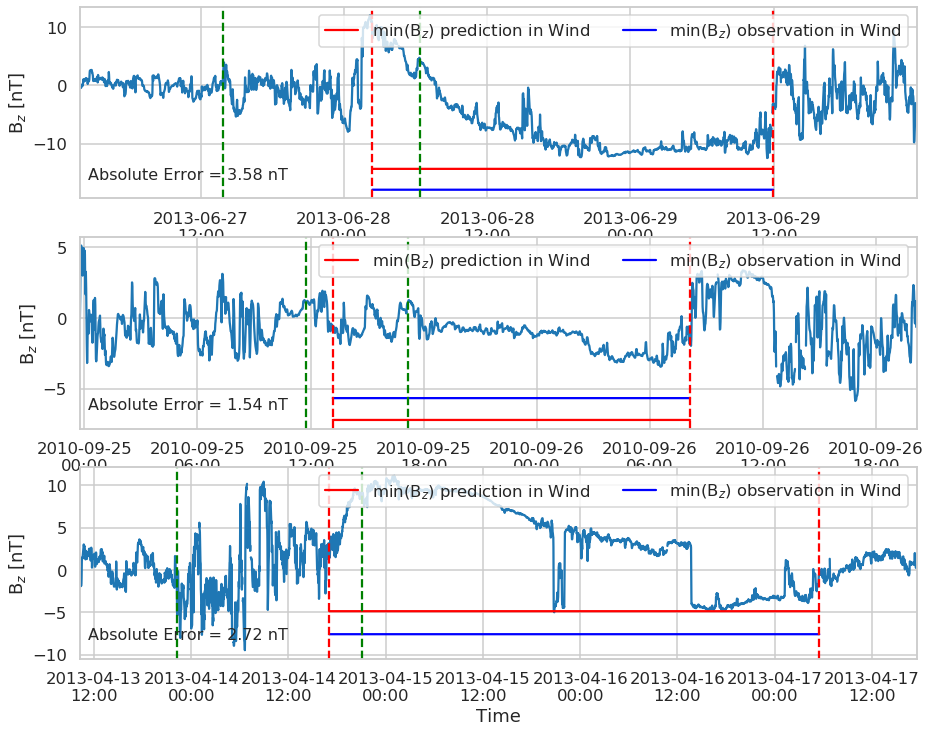

In [31]:
#Example in Figure 1:
y_pred = y_pred3
plot_all_mos(win, n_iwinind, 17, 20, 'Wind')

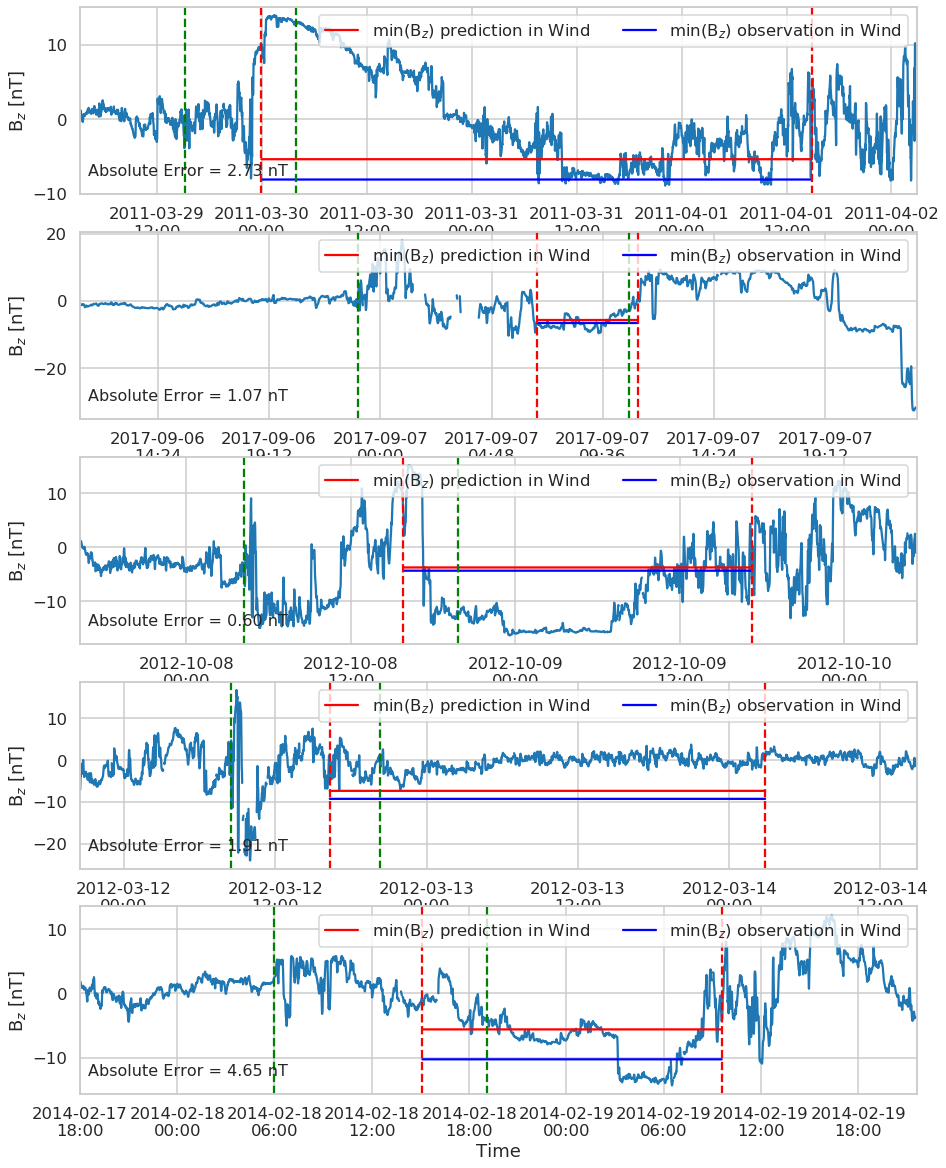

In [32]:
y_pred = y_pred2
start_range, end_range = 0, np.size(win_test_ind)
plot_all_mos(win, n_iwinind, 0, 5, 'Wind')
#start_range, end_range = len(win_test_ind), len(win_test_ind) + len(sta_test_ind)
#plot_all_mos(sta, n_istaind, start_range, end_range, 'STEREO-A')
#start_range, end_range = len(win_test_ind) + len(sta_test_ind), len(test_ind)
#plot_all_mos(stb, n_istbind, start_range, end_range, 'STEREO-B')